![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 2 - Clasificación de género de películas

El propósito de este proyecto es que puedan poner en práctica, en sus respectivos grupos de trabajo, sus conocimientos sobre técnicas de preprocesamiento, modelos predictivos de NLP, y la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 2: Clasificación de género de películas"

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 8. Sin embargo, es importante que avancen en la semana 7 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 8, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/2c54d005f76747fe83f77fbf8b3ec232).

## Datos para la predicción de género en películas

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/moviegenre.png)

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

La idea es que usen estos datos para predecir la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

## Ejemplo predicción conjunto de test para envío a Kaggle
En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación librerías
import pandas as pd
import os
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
import nltk
import re
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [4]:
# Visualización datos de entrenamiento
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [5]:
# Visualización datos de test
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [6]:
import re
#Limpieza
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

dataTraining['clean_plot'] = dataTraining['plot'].apply(lambda x: clean_text(x))
dataTraining.head(5)

,year,title,plot,genres,rating,clean_plot
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0,most is the story of a single father who takes...
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6,a serial killer decides to teach the secrets o...
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2,in sweden a female blackmailer with a disfigur...
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4,in a friday afternoon in new york the presiden...
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6,in los angeles the editor of a publishing hous...


Total de géneros: 24
crime          1447
animation       260
action         1303
thriller       2024
sport           261
horror          954
western         237
musical         271
romance        1892
drama          3965
comedy         3046
documentary     419
news              7
adventure      1024
music           582
film-noir       168
sci-fi          723
history         273
biography       373
family          682
mystery         759
short            92
fantasy         707
war             348
dtype: int64


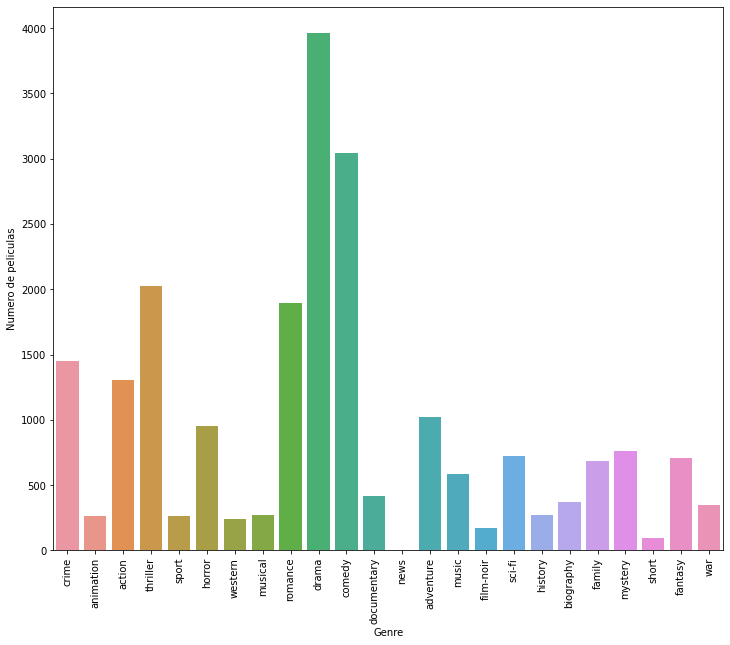

In [7]:
#Géneros------------------------------------------
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

all_genres = []
for value in dataTraining['genres']:
  data = value.replace("['","").replace("']","").split("', '")
  all_genres.extend(data)

print('Total de géneros: '+ str(len(set(all_genres))))

unique_list  = list(set(all_genres))
for genre in unique_list:
  dataTraining[genre.lower()] = dataTraining['genres'].apply(lambda x: 1 if genre in x else 0)

#Comprobación
#print(dataTraining[dataTraining['genres'].str.contains("Short")])
  
##Numero de peliculas por genero
category_columns = dataTraining.columns.drop(['year', 'title', 'plot','genres','rating','clean_plot'])
sum_genre = dataTraining[category_columns].sum()
print(sum_genre)
df_movies_per_genre = pd.DataFrame({'Genre':category_columns, 'Total': sum_genre})

f, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.barplot(data=df_movies_per_genre, x='Genre', y='Total', axes=ax)
ax.set(ylabel='Numero de peliculas')
plt.xticks(rotation=90)
plt.show()

In [8]:
# Visualización datos de entrenamiento con categorias
dataTraining.head()

,year,title,plot,genres,rating,clean_plot,crime,animation,action,thriller,...,music,film-noir,sci-fi,history,biography,family,mystery,short,fantasy,war
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0,most is the story of a single father who takes...,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6,a serial killer decides to teach the secrets o...,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2,in sweden a female blackmailer with a disfigur...,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4,in a friday afternoon in new york the presiden...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6,in los angeles the editor of a publishing hous...,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


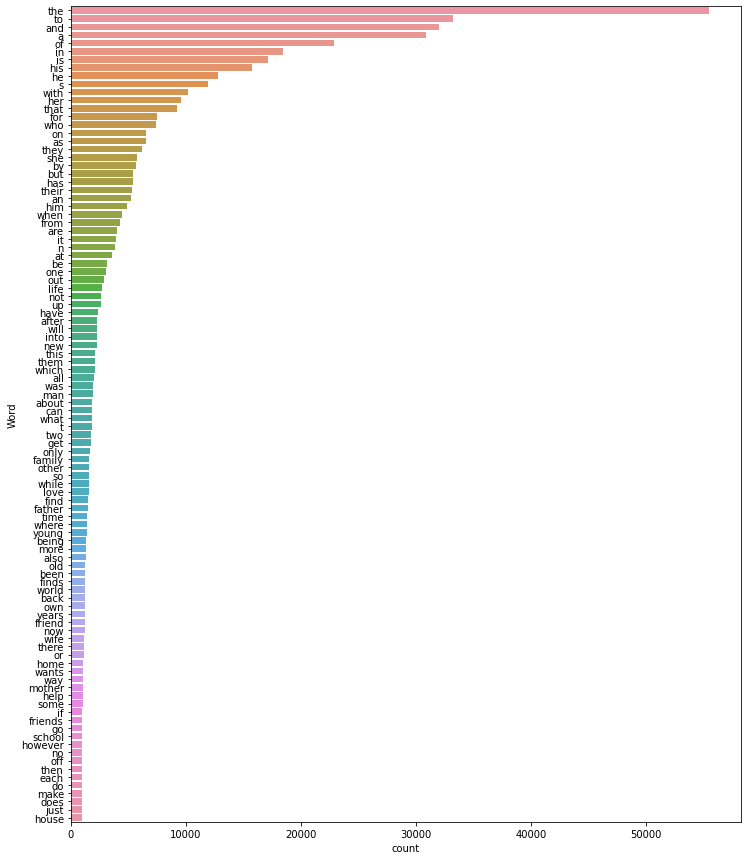

In [9]:
import matplotlib.pyplot as plt 
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(dataTraining['clean_plot'], 100)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


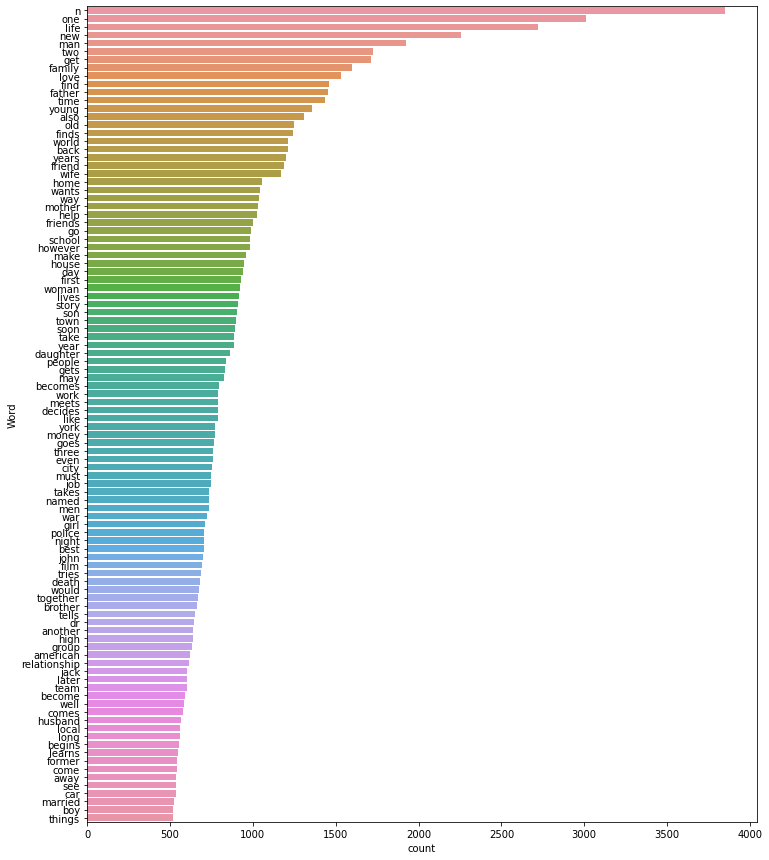

In [10]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

#Remover stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

dataTraining['clean_plot'] = dataTraining['clean_plot'].apply(lambda x: remove_stopwords(x))

freq_words(dataTraining['clean_plot'], 100)
#Aquí se puede notar cómo cambiaron las palabras frecuentes 

In [11]:
# Definición de variables predictoras (X)
vect = TfidfVectorizer(min_df=3)
X_dtm = vect.fit_transform(dataTraining['clean_plot'])
X_dtm.shape

(7895, 15656)

In [12]:
import nltk
from nltk.stem import WordNetLemmatizer

vect1 = TfidfVectorizer()
vect1.fit(dataTraining['clean_plot'])
words = list(vect1.vocabulary_.keys())[:100]
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
print([wordnet_lemmatizer.lemmatize(word,pos='v') for word in words])
def split_into_lemmas(text):
    text = text.lower()
    words = text.split()
    return [wordnet_lemmatizer.lemmatize(word) for word in words]

vect_lemas = TfidfVectorizer(analyzer=split_into_lemmas)
X_train_l = vect_lemas.fit_transform(dataTraining['clean_plot'])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
['story', 'single', 'father', 'take', 'eight', 'year', 'old', 'son', 'work', 'railroad', 'drawbridge', 'bridge', 'tender', 'day', 'boy', 'meet', 'woman', 'board', 'train', 'drug', 'abuser', 'go', 'engine', 'room', 'tell', 'stay', 'edge', 'nearby', 'lake', 'ship', 'come', 'lift', 'though', 'suppose', 'arrive', 'hour', 'later', 'happen', 'see', 'try', 'warn', 'able', 'see', 'oncoming', 'approach', 'fall', 'gear', 'work', 'attempt', 'lower', 'leave', 'horrific', 'choice', 'lower', 'gear', 'crush', 'people', 'completely', 'oblivious', 'fact', 'die', 'try', 'save', 'addict', 'happen', 'look', 'window', 'movie', 'end', 'man', 'wander', 'new', 'city', 'longer', 'hold', 'small', 'baby', 'relevant', 'narratives', 'run', 'parallel', 'namely', 'one', 'female', 'meet', 'climax', 'tumultuous', 'film', 'serial', 'killer', 'decide', 'teach', 'secrets', 'satisfy', 'career', 'video', 'store', 'cle

In [13]:
# Definición de variable de interés (y)
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [15]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_train_l, y_genres, test_size=0.33, random_state=10)

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
param_grid_lr = {
    'max_iter': [20, 50, 100, 500, 1000],                      
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],                                      
}
grid = GridSearchCV(estimator=LogisticRegression(random_state=10), param_grid=param_grid_lr, verbose=1, cv=5, n_jobs=-1)
clf9 = OneVsRestClassifier(grid)
clf9.fit(X_train, y_train_genres)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 

OneVsRestClassifier(estimator=GridSearchCV(cv=5,
                                           estimator=LogisticRegression(random_state=10),
                                           n_jobs=-1,
                                           param_grid={'max_iter': [20, 50, 100,
                                                                    500, 1000],
                                                       'solver': ['newton-cg',
                                                                  'lbfgs',
                                                                  'liblinear',
                                                                  'sag',
                                                                  'saga']},
                                           verbose=1))

In [18]:
# Disponibilidad del modelo 
import joblib
joblib.dump(clf9, 'clf.pkl', compress=3)

['clf.pkl']

In [19]:
# Predicción del modelo de clasificación
y_pred_genres9 = clf9.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres9, average='macro')

0.8892254422277946

In [21]:
# transformación variables predictoras X del conjunto de test
#Limpieza
dataTesting['clean_plot'] = dataTesting['plot'].apply(lambda x: clean_text(x))
#Remover stopwords
dataTesting['clean_plot'] = dataTesting['clean_plot'].apply(lambda x: remove_stopwords(x))

X_test_dtm = vect_lemas.transform(dataTesting['clean_plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

# Predicción del conjunto de test
y_pred_test_genres = clf9.predict_proba(X_test_dtm)

In [22]:
# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_text_RF.csv', index_label='ID')
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.133675,0.091068,0.028610,0.036108,0.328867,0.134365,0.032245,0.561653,0.060755,0.110721,...,0.036344,0.126049,0.001101,0.439793,0.068691,0.011071,0.027775,0.232261,0.027554,0.027642
4,0.167638,0.054966,0.030779,0.094618,0.263523,0.308131,0.053209,0.764951,0.038391,0.039577,...,0.029127,0.044207,0.001223,0.091493,0.032793,0.012104,0.031947,0.317157,0.044258,0.021604
5,0.117797,0.052142,0.016371,0.058389,0.216666,0.636870,0.035649,0.666964,0.029951,0.038499,...,0.022888,0.289226,0.001277,0.180076,0.076164,0.009985,0.025506,0.481685,0.031666,0.022709
6,0.129371,0.083559,0.022820,0.049855,0.216188,0.104082,0.031811,0.643355,0.063610,0.049265,...,0.031407,0.079535,0.001123,0.221659,0.104890,0.010362,0.030883,0.353881,0.062484,0.022904
7,0.083975,0.093230,0.026279,0.029643,0.201150,0.133198,0.041954,0.256544,0.058697,0.089378,...,0.027809,0.124208,0.001107,0.180897,0.336689,0.012365,0.017976,0.404986,0.022214,0.018825
